# Explore

In [1]:
import pandas as pd

import unicodedata
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from wordcloud import WordCloud

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from acquire import get_news_articles
from prepare import prep_article_data

## Exercise 1 Spam Data
- Load the spam data set.
 

In [2]:
df = pd.read_csv('spam.csv', 
                 encoding='latin-1',
                 usecols=[0,1]) # use first 2 columns only to get rid of unnamed columns full of nans
df.columns = ['label', 'text']
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
def basic_clean(text):
    text = (unicodedata.normalize('NFKD', text.lower())
            .encode('ascii', 'ignore') # ascii to reduce noise
            .decode('utf-8', 'ignore') # decode using utf-8
           )
    return re.sub(r"[^a-z0-9\s]", '', text)

In [4]:
df['text_cleaned'] = df.text.apply(basic_clean)

In [5]:
def tokenize(string):
    '''
    This function takes in a string and
    returns a tokenized string.
    '''
    # Create tokenizer.
    tokenizer = nltk.tokenize.ToktokTokenizer()
    
    # Use tokenizer
    string = tokenizer.tokenize(string, return_str=True)
    
    return string

In [6]:
df['text_tokenized'] = df.text_cleaned.apply(tokenize)

In [7]:
def lemmatize(string):
    '''
    This function takes in string for and
    returns a string with words lemmatized.
    '''
    # Create the lemmatizer.
    wnl = nltk.stem.WordNetLemmatizer()
    
    # Use the lemmatizer on each word in the list of words we created by using split.
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    
    # Join our list of words into a string again and assign to a variable.
    string = ' '.join(lemmas)
    
    return string

In [8]:
df['text_lemmatized'] = df.text_tokenized.apply(lemmatize)

In [9]:
def remove_stopwords(string, extra_words=[], exclude_words=[]):
    '''
    This function takes in a string, optional extra_words and exclude_words parameters
    with default empty lists and returns a string.
    '''
    # Create stopword_list.
    stopword_list = stopwords.words('english')
    
    # Remove 'exclude_words' from stopword_list to keep these in my text.
    stopword_list = set(stopword_list) - set(exclude_words)
    # Add in 'extra_words' to stopword_list.
    stopword_list = stopword_list.union(set(extra_words))
    
    # Split words in string.
    words = string.split()
    
    # Create a list of words from my string with stopwords removed and assign to variable.
    filtered_words = [word for word in words if word not in stopword_list]
    
    # Join words in the list back into strings and assign to a variable.
    string_without_stopwords = ' '.join(filtered_words)
    
    return string_without_stopwords



In [10]:
df['text_filtered'] = df.text_lemmatized.apply(remove_stopwords)

In [11]:
words = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in df.text_filtered]
# words 

# column name will be words, and the column will contain lists of the words in each doc
df = pd.concat([df, pd.DataFrame({'words': words})], axis=1)

In [12]:
ham_words = ' '.join(df[df.label=='ham'].text_filtered)
spam_words = ' '.join(df[df.label=='spam'].text_filtered)
all_words = ' '.join(df.text_filtered)

ham_words = re.sub(r'\s.\s', '', ham_words)
spam_words = re.sub(r'\s.\s', '', spam_words)
all_words = re.sub(r'\s.\s', '', all_words)

In [13]:
ham_freq = pd.Series(ham_words.split()).value_counts()
spam_freq = pd.Series(spam_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [14]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
               .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

 - Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?
    

#### Spam Bigrams

In [15]:
spam_bigrams = pd.Series(list(nltk.ngrams(spam_words.split(), 2))).value_counts().head(20)

In [16]:
spam_bigrams

(please, call)          43
(customer, service)     27
(guaranteed, call)      23
(po, box)               23
(prize, guaranteed)     22
(a1000, cash)           20
(send, stop)            19
(every, week)           19
(land, line)            18
(await, collection)     18
(urgent, mobile)        18
(valid, 12hrs)          17
(sae, tc)               16
(account, statement)    16
(claim, call)           16
(call, customer)        15
(identifier, code)      15
(call, mobileupd8)      15
(reply, call)           15
(call, 08000930705)     15
dtype: int64

In [17]:
data_spam_bigrams = {k[0] + ' ' + k[1]: v for k, v in spam_bigrams.to_dict().items()}

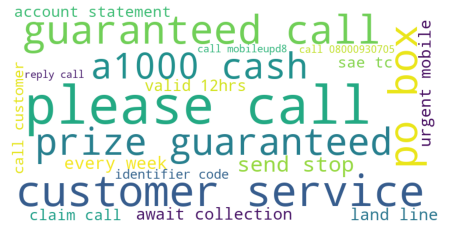

In [18]:
img = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(data_spam_bigrams)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Ham Bigrams

In [19]:
ham_bigrams = pd.Series(list(nltk.ngrams(ham_words.split(), 2))).value_counts().head(20)

In [20]:
ham_bigrams

(call, later)      47
(ill, call)        45
(let, know)        41
(sorry, ill)       39
(dont, know)       31
(good, morning)    31
(new, year)        26
(pls, send)        22
(take, care)       21
(ok, lor)          20
(im, going)        20
(good, night)      19
(im, gonna)        19
(ltgt, min)        19
(hi, hi)           18
(last, night)      18
(great, day)       17
(happy, new)       15
(like, ltgt)       14
(send, message)    14
dtype: int64

In [21]:
data_ham_bigrams = {k[0] + ' ' + k[1]: v for k, v in ham_bigrams.to_dict().items()}

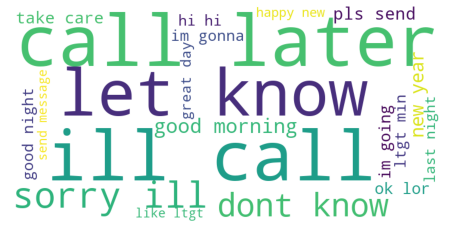

In [22]:
img = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(data_ham_bigrams)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

- Is there any overlap in the bigrams for the spam data and the ham data?
  

There are no bigrams that overlap but the single word call does

- Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

#### Spam Trigrams

In [23]:
spam_trigrams = pd.Series(list(nltk.ngrams(spam_words.split(), 3))).value_counts().head(20)

In [24]:
spam_trigrams

(prize, guaranteed, call)              21
(call, customer, service)              15
(land, line, claim)                    14
(2003, account, statement)             13
(private, 2003, account)               13
(reply, call, 08000930705)             13
(show, 800, unredeemed)                12
(guaranteed, a1000, cash)              12
(camcorder, reply, call)               12
(bonus, caller, prize)                 11
(anytime, network, min)                11
(every, week, txt)                     11
(please, call, customer)               10
(cash, await, collection)              10
(a2000, bonus, caller)                 10
(customer, service, representative)    10
(urgent, mobile, number)                9
(mobile, number, ha)                    9
(800, unredeemed, point)                9
(contacttoday, draw, show)              9
dtype: int64

In [25]:
data_spam_trigrams = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in spam_trigrams.to_dict().items()}

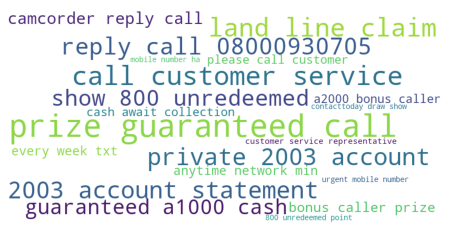

In [26]:
img = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(data_spam_trigrams)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Ham Trigrams

In [27]:
ham_trigrams = pd.Series(list(nltk.ngrams(ham_words.split(), 3))).value_counts().head(20)

In [28]:
ham_trigrams

(ill, call, later)             38
(sorry, ill, call)             38
(happy, new, year)             13
(cant, pick, phone)            12
(pls, send, message)           12
(phone, right, pls)            12
(right, pls, send)             12
(pick, phone, right)           12
(hi, hi, hi)                   11
(good, morning, dear)           7
(pls, convey, birthday)         6
(kiss, across, sea)             6
(convey, birthday, wish)        6
(askdlunch, lunch, invited)     5
(caller, presscopy, friend)     5
(week, wa, bday)                5
(bday, bos, felt)               5
(wish, parent, forgotkid)       5
(love, go, day)                 5
(minute, ok, sed)               5
dtype: int64

In [29]:
data_ham_trigrams = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in ham_trigrams.to_dict().items()}

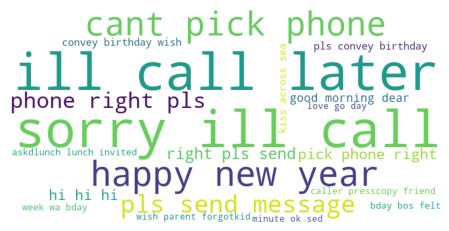

In [30]:
img = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(data_ham_trigrams)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

bonus: plot document length information of spam vs. ham. Does there appear to be a difference? 

## Exercise 2

Explore the news articles using the techniques discussed in the exploration
   lesson. Use the `category` variable when exploring.

In [31]:
df = get_news_articles(cached=True)

In [32]:
df

,topic,title,author,content
0,business,"Lakshmi Vilas Bank withdrawals capped at ₹25,0...",Pragya Swastik,The Centre has imposed a 30-day moratorium on ...
1,business,Shutting Delhi markets may prove counterproduc...,Sakshita Khosla,Traders' body CAIT on Tuesday said a proposal ...
2,business,Pfizer shares drop 4.5% as Moderna says its va...,Krishna Veera Vanamali,Pfizer’s shares fell as much as 4.5% on Monday...
3,business,How does Moderna's COVID-19 vaccine candidate ...,Pragya Swastik,Moderna's initial results of late-stage trial ...
4,business,"Musk gets $15bn richer in 2 hours, becomes wor...",Krishna Veera Vanamali,Billionaire Elon Musk added $15 billion to his...
...,...,...,...,...
94,entertainment,"I'm a romantic at heart, that influences my so...",Kriti Sharma,"During a recent interview, singer Amaal Mallik..."
95,entertainment,"Heroes can be larger than life, but emotions h...",Kriti Sharma,Actor Suriya Sivakumar said he believes that I...
96,entertainment,Aditya to start shooting for upcoming action f...,Kriti Sharma,Actor Aditya Roy Kapur will start shooting for...
97,entertainment,Feeling a little scared: Neetu on shooting for...,Kriti Sharma,Sharing a picture from the sets of her upcomin...


In [33]:
prep_article_data(df, 'content')

,topic,title,content,stemmed,lemmatized,clean
0,business,"Lakshmi Vilas Bank withdrawals capped at ₹25,0...",The Centre has imposed a 30-day moratorium on ...,the centr ha impos a 30day moratorium on laksh...,the centre ha imposed a 30day moratorium on la...,centre imposed 30day moratorium lakshmi vila b...
1,business,Shutting Delhi markets may prove counterproduc...,Traders' body CAIT on Tuesday said a proposal ...,trader bodi cait on tuesday said a propos to i...,trader body cait on tuesday said a proposal to...,trader body cait tuesday said proposal impose ...
2,business,Pfizer shares drop 4.5% as Moderna says its va...,Pfizer’s shares fell as much as 4.5% on Monday...,pfizer share fell as much as 45 on monday afte...,pfizers share fell a much a 45 on monday after...,pfizers share fell much 45 monday rival modern...
3,business,How does Moderna's COVID-19 vaccine candidate ...,Moderna's initial results of late-stage trial ...,moderna initi result of latestag trial show it...,modernas initial result of latestage trial sho...,modernas initial result latestage trial show c...
4,business,"Musk gets $15bn richer in 2 hours, becomes wor...",Billionaire Elon Musk added $15 billion to his...,billionair elon musk ad 15 billion to hi wealt...,billionaire elon musk added 15 billion to his ...,billionaire elon musk added 15 billion wealth ...
...,...,...,...,...,...,...
94,entertainment,"I'm a romantic at heart, that influences my so...","During a recent interview, singer Amaal Mallik...",dure a recent interview singer amaal mallik me...,during a recent interview singer amaal mallik ...,recent interview singer amaal mallik mentioned...
95,entertainment,"Heroes can be larger than life, but emotions h...",Actor Suriya Sivakumar said he believes that I...,actor suriya sivakumar said he believ that ind...,actor suriya sivakumar said he belief that ind...,actor suriya sivakumar said belief indian film...
96,entertainment,Aditya to start shooting for upcoming action f...,Actor Aditya Roy Kapur will start shooting for...,actor aditya roy kapur will start shoot for hi...,actor aditya roy kapur will start shooting for...,actor aditya roy kapur start shooting upcoming...
97,entertainment,Feeling a little scared: Neetu on shooting for...,Sharing a picture from the sets of her upcomin...,share a pictur from the set of her upcom film ...,sharing a picture from the set of her upcoming...,sharing picture set upcoming film jug jugg jee...


In [36]:
df.topic.value_counts()

business         25
sports           25
technology       25
entertainment    24
Name: topic, dtype: int64

In [39]:
business_words = ' '.join(df[df.topic=='business'].clean)
sports_words = ' '.join(df[df.topic=='sports'].clean)
technology_words = ' '.join(df[df.topic=='technology'].clean)
entertainment_words = ' '.join(df[df.topic=='entertainment'].clean)
all_words = ' '.join(df.clean)

business_words = re.sub(r'\s.\s', '', business_words)
sports_words = re.sub(r'\s.\s', '', sports_words)
technology_words = re.sub(r'\s.\s', '', technology_words)
entertainment_words = re.sub(r'\s.\s', '', entertainment_words)
all_words = re.sub(r'\s.\s', '', all_words)

In [41]:
business_freq = pd.Series(business_words.split()).value_counts()
sports_freq = pd.Series(sports_words.split()).value_counts()
technology_freq = pd.Series(technology_words.split()).value_counts()
entertainment_freq = pd.Series(entertainment_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [42]:
word_counts = (pd.concat([all_freq, business_freq, sports_freq, technology_freq, entertainment_freq], axis=1, sort=True)
               .set_axis(['all', 'business', 'sports', 'technology', 'entertainment'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

In [43]:
word_counts

,all,business,sports,technology,entertainment
10,3,3,0,0,0
100,3,1,2,0,0
100000,1,0,0,1,0
103,1,1,0,0,0
109,1,0,1,0,0
...,...,...,...,...,...
zazie,1,0,0,0,1
zealand,1,0,1,0,0
zoom,2,0,0,2,0
zoombombers,1,0,0,1,0


In [44]:
business_bigrams = pd.Series(list(nltk.ngrams(business_words.split(), 2))).value_counts().head(20)

In [46]:
business_bigrams

(covid19, vaccine)       4
(stake, mitsubishi)      3
(said, nissan)           3
(vaccine, 945)           3
(monday, said)           3
(945, effective)         3
(mitsubishi, motor)      3
(vaccine, 90)            2
(airasia, india)         2
(tuesday, said)          2
(28c, 30)                2
(stored, normal)         2
(pfizers, vaccine)       2
(amid, covid19)          2
(fridge, temperature)    2
(said, experimental)     2
(temperature, 28c)       2
(three, year)            2
(next, year)             2
(economic, forecast)     2
dtype: int64

In [48]:
data_business_bigrams = {k[0] + ' ' + k[1]: v for k, v in business_bigrams.to_dict().items()}

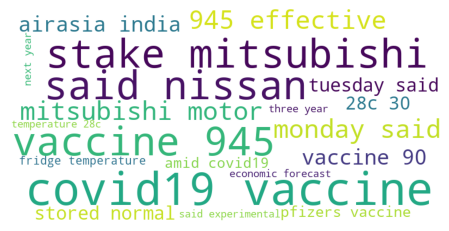

In [49]:
img = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(data_business_bigrams)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [50]:
sports_bigrams = pd.Series(list(nltk.ngrams(sports_words.split(), 2))).value_counts().head(20)

In [51]:
sports_bigrams

(virat, kohli)         5
(rohit, sharma)        4
(team, india)          4
(captain, virat)       3
(test, series)         3
(india, captain)       3
(former, australia)    3
(west, indie)          3
(south, australia)     2
(mega, auction)        2
(shakib, al)           2
(glenn, mcgrath)       2
(said, india)          2
(cummins, said)        2
(let, go)              2
(pick, right)          2
(first, test)          2
(al, hasan)            2
(tested, positive)     2
(mpl, sport)           2
dtype: int64

In [52]:
data_sports_bigrams = {k[0] + ' ' + k[1]: v for k, v in sports_bigrams.to_dict().items()}

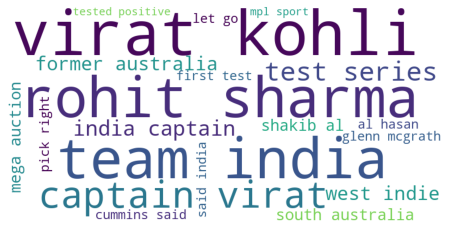

In [54]:
img = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(data_sports_bigrams)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [55]:
technology_bigrams = pd.Series(list(nltk.ngrams(technology_words.split(), 2))).value_counts().head(20)

In [56]:
technology_bigrams

(social, medium)          4
(ott, platform)           2
(ceo, jack)               2
(twitter, ceo)            2
(also, discussed)         2
(police, said)            2
(vice, presidentelect)    2
(500, index)              2
(international, space)    2
(mexico, due)             2
(crew, dragon)            2
(jack, dorsey)            2
(said, apple)             2
(new, mexico)             2
(bad, film)               2
(mac, user)               2
(new, york)               2
(kamala, harris)          2
(elon, musk)              2
(discus, issue)           2
dtype: int64

In [57]:
data_technology_bigrams = {k[0] + ' ' + k[1]: v for k, v in technology_bigrams.to_dict().items()}

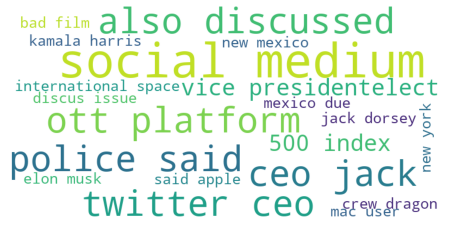

In [63]:
img = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(data_technology_bigrams)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [64]:
entertainment_bigrams = pd.Series(list(nltk.ngrams(entertainment_words.split(), 2))).value_counts().head(20)

In [65]:
entertainment_bigrams

(added, actor)            4
(played, villain)         2
(actor, suriya)           2
(indian, film)            2
(suriya, sivakumar)       2
(comedy, movie)           2
(aditya, roy)             2
(experience, working)     2
(feel, comfortable)       2
(award, comedy)           2
(roy, kapur)              2
(late, actor)             2
(made, feel)              2
(france, highest)         2
(joey, king)              2
(watch, movie)            1
(find, feeling)           1
(aaron, taylorjohnson)    1
(series, hacked)          1
(1999, movie)             1
dtype: int64

In [66]:
data_entertainment_bigrams = {k[0] + ' ' + k[1]: v for k, v in entertainment_bigrams.to_dict().items()}

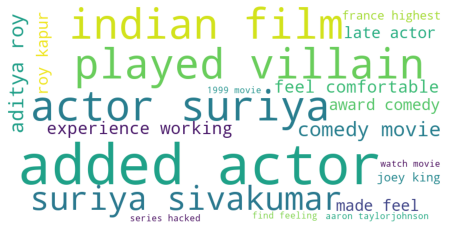

In [67]:
img = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(data_entertainment_bigrams)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()